<font face = "Times New Roman">

# Adaboost with KNN On MNIST Dataset

In this notebook, I will show how to use Adaboost with KNN. The idea is to use KNN as a weak learner in Adaboost. 

## 1. Load the dataset

I use the MNIST dataset in this notebook. The MNIST dataset is a large database of handwritten digits that is commonly used for training various image processing systems. 

There are four files in the dataset, including `train-images-idx3-ubyte`, `train-labels-idx1-ubyte`, `t10k-images-idx3-ubyte`, and `t10k-labels-idx1-ubyte`. 
* `train-images-idx3-ubyte` contains the training data, which is used to train the model.
* `train-labels-idx1-ubyte` contains the labels for the training data.
* `t10k-images-idx3-ubyte` contains the test data, which is used to evaluate the model.
* `t10k-labels-idx1-ubyte` contains the labels for the test data.

In the MNIST dataset, each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training data contains 60000 images, and the test data contains 10000 images.

First, I will load the data and show some examples.

</font>

<font face = "Times New Roman">

#### Function to load the images and labels


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_mnist_images(filename):
    with open(filename, 'rb') as fp:
        magic = int.from_bytes(fp.read(4), byteorder='big')
        assert magic == 2051, f"Bad magic number in {filename}"
        
        num_images = int.from_bytes(fp.read(4), byteorder='big') # number of images
        num_rows = int.from_bytes(fp.read(4), byteorder='big')   # number of rows
        num_cols = int.from_bytes(fp.read(4), byteorder='big')   # number of columns
        
        raw_images = np.frombuffer(fp.read(), dtype=np.uint8)
        images = np.reshape(raw_images, (num_images, num_rows, num_cols))
        images = np.transpose(images, (1, 2, 0))
        
        images = np.reshape(images, (num_rows * num_cols, num_images))
        images = images.astype(np.float32) / 255.0              # normalize to [0, 1]
        
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as fp:
        magic = int.from_bytes(fp.read(4), byteorder='big')
        assert magic == 2049, f"Bad magic number in {filename}"
        
        num_labels = int.from_bytes(fp.read(4), byteorder='big')
        raw_labels = np.frombuffer(fp.read(), dtype=np.uint8)
        
    return raw_labels


<font face = "Times New Roman">

#### Load the Training dataset

In [3]:
images_filename = 'train-images-idx3-ubyte'
labels_filename = 'train-labels-idx1-ubyte'
images = load_mnist_images(images_filename)
labels = load_mnist_labels(labels_filename)

<font face = "Times New Roman">

#### Display the first 10 images and their labels

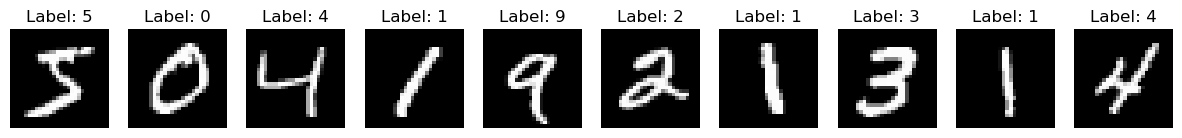

In [4]:
num_images_to_show = 10
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    axes[i].imshow(np.reshape(images[:, i], (28, 28)), cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.show()

<font face = "Times New Roman">

## 2. Naive KNN Classifier

In this section, I will implement a naive KNN classifier. The KNN algorithm is a simple, easy-to-implement, and versatile algorithm. It is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation.

> Note : Here , I use KNN with n = 5 uniform and auto.

#### Preprocessing the data

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


# Load training data
X_train = load_mnist_images('train-images-idx3-ubyte')
y_train = load_mnist_labels('train-labels-idx1-ubyte')

#print(X_train.shape)
#print(y_train.shape)

# Load test data
X_test = load_mnist_images('t10k-images-idx3-ubyte')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte')

# Reshape images to flat vectors
X_train = X_train.T  # Transpose to have samples as rows
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images
X_test = X_test.T  # Transpose to have samples as rows
X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten images

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


<font face = "Times New Roman">

#### Implementing the KNN algorithm

In [7]:

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9443


<font face = "Times New Roman">

#### Visualization of some of the test images and their predicted labels [Randomly selected]

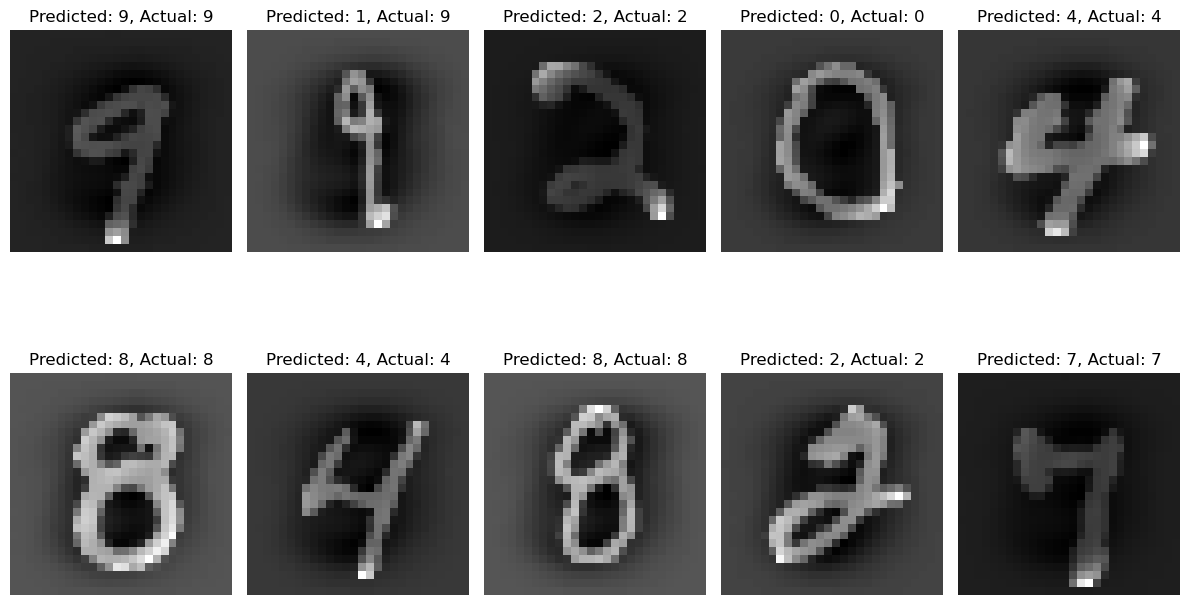

In [8]:
# Choose random indices to visualize
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Predict labels for the chosen test samples
predicted_labels = knn.predict(X_test[random_indices])

# Visualize the test images along with their predicted labels
plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}, Actual: {y_test[index]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


<font face = "Times New Roman">

However , the accuracy of the KNN model is already good enough. So when testing the Adaboost with KNN model, the result may be not that trivial.

Therefore, I cut the training data to 100 images and try KNN again

In [16]:
# Load training data
X_train = load_mnist_images('train-images-idx3-ubyte')
y_train = load_mnist_labels('train-labels-idx1-ubyte')

# Randomly select 50 training samples
random_indices = np.random.choice(len(X_train), 50, replace=False)
X_train = X_train[:, random_indices]
y_train = y_train[random_indices]


# Load test data
X_test = load_mnist_images('t10k-images-idx3-ubyte')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte')

# Reshape images to flat vectors
X_train = X_train.T  # Transpose to have samples as rows
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images
X_test = X_test.T  # Transpose to have samples as rows
X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten images

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



<font face = "Times New Roman">

Train Again with 50 images:We can see that the accuracy is not that good.

In [20]:
for i in range(1, 8):    
    # Initialize kNN classifier
    knn = KNeighborsClassifier(n_neighbors=i)

    # Train the classifier
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Neighbours{i}:Accuracy:", accuracy)

Neighbours1:Accuracy: 0.5925
Neighbours2:Accuracy: 0.5233
Neighbours3:Accuracy: 0.5264
Neighbours4:Accuracy: 0.5374
Neighbours5:Accuracy: 0.5358
Neighbours6:Accuracy: 0.519
Neighbours7:Accuracy: 0.5127


<font face = "Times New Roman">

Visualize some of the test images and their predicted labels [Randomly selected]

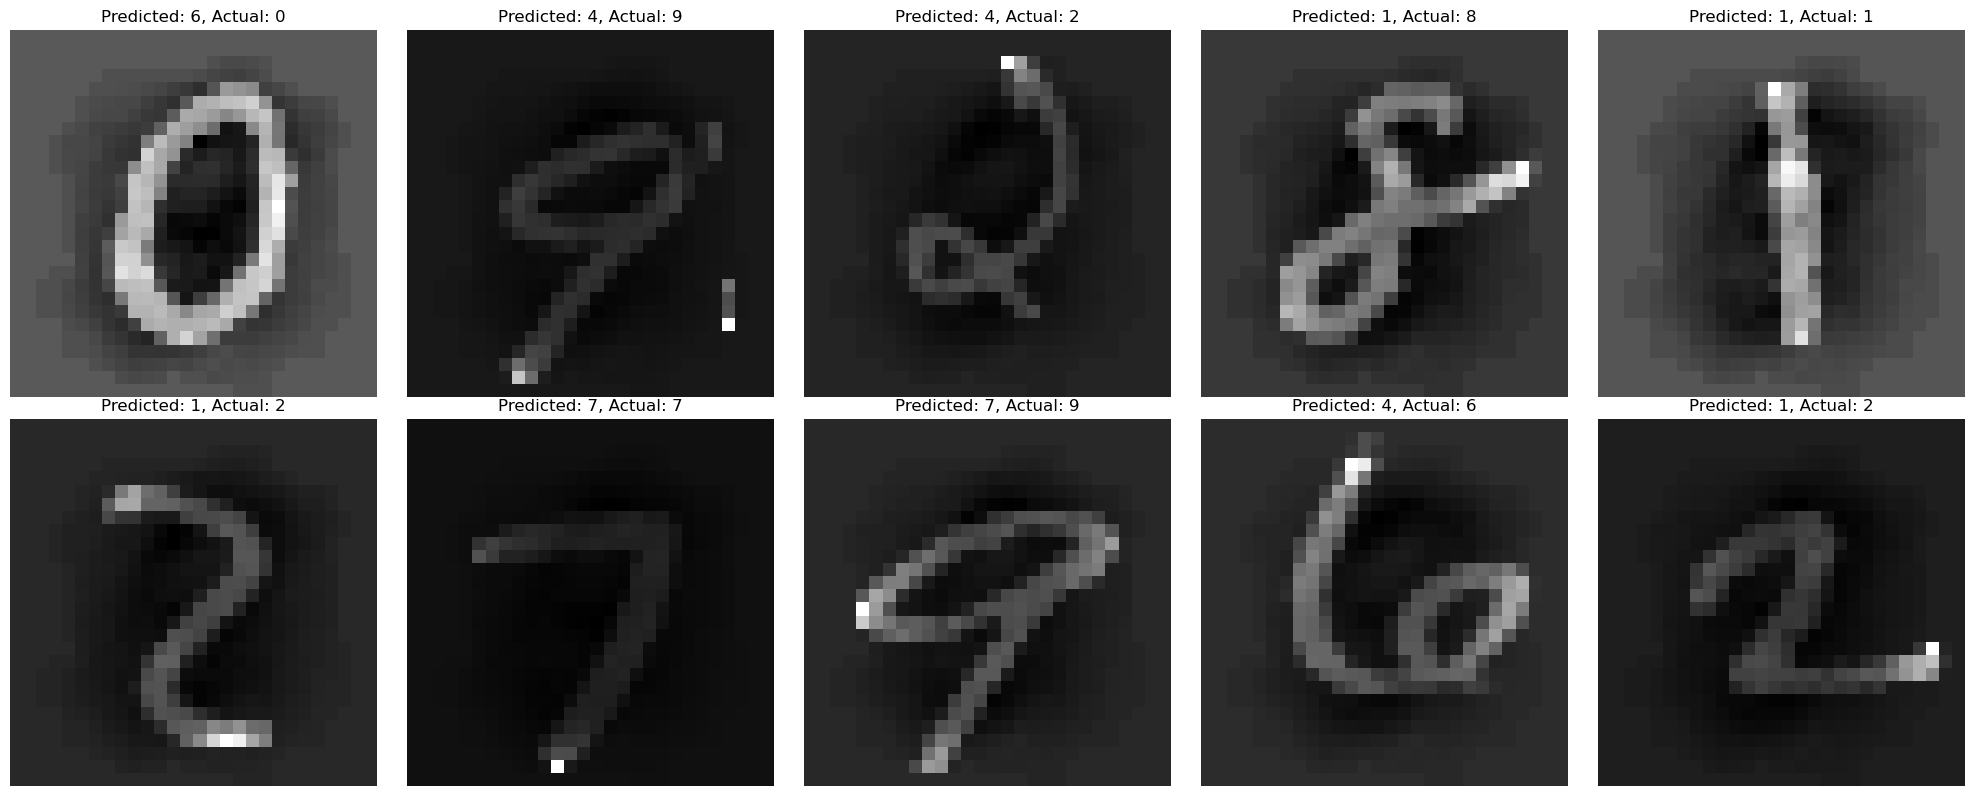

In [21]:
# Choose random indices to visualize
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Predict labels for the chosen test samples
predicted_labels = knn.predict(X_test[random_indices])

# Visualize the test images along with their predicted labels
plt.figure(figsize=(20, 8))
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}, Actual: {y_test[index]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


<font face = "Times New Roman">

## 3. Adaboost with KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import accuracy_score

class Adaboost:
    ########################################
    #  Adaboost with KNN weak learners     #
    #  Parameters:                         #
    #  n_estimators: int                   #
    ########################################
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators    # Number of weak learners
        self.estimator_weights = []         # List to store weights of weak learners
        self.best_estimators = []

    ###############################################
    #  Fit the model with training data           #
    #  Parameters:                                #    
    #  X: np.array, shape (n_samples, n_features) #
    #  y: np.array, shape (n_samples,)            #
    ###############################################
    def fit(self, X, y, X_test, y_test):
        n_samples = X_test.shape[0]
        sample_weights = np.full(n_samples, (1 / n_samples))
        #########################################
        #  Iterate through the weak learners    #
        #########################################
        for i in range(self.n_estimators):
            min_error = float('inf')
            best_params = {}
            neighbor_list = [1, 2, 3,4, 5]
            weight_list = ['distance', 'uniform']
            algorithm_list = ['auto', 'kd_tree', 'brute']
            metric_list = ['euclidean', 'manhattan', 'minkowski']

            best_estimator = None
            best_incorrect = None

            #########################################
            #  Iterate through the KNN parameters  #
            #########################################
            for neighbor in neighbor_list:
                for weight in weight_list:
                    for algorithm in algorithm_list:
                        for metric in metric_list:
                            estimator = KNeighborsClassifier(
                                n_neighbors=neighbor, 
                                weights=weight, 
                                algorithm=algorithm, 
                                metric=metric
                            )
                            estimator.fit(X, y)
                            # Make predictions
                            y_pred = estimator.predict(X_test)
                            # Compute error
                            incorrect = (y_pred != y_test)
                            error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)
                            print(f"Neighbors: {neighbor} Weight: {weight} Algorithm: {algorithm} Metric: {metric} Error: {error}")
                            if error <= min_error:
                                min_error = error
                                best_estimator = estimator
                                best_params = {
                                    'neighbor': neighbor,
                                    'weight': weight,
                                    'algorithm': algorithm,
                                    'metric': metric
                                }
                                best_incorrect = incorrect

            # Store the best weak learner
            print(f"Iteration {i+1} Best Params: {best_params} Best Error: {min_error}")
            error = min_error

            # Compute estimator weight
            estimator_weight = 0.5 * np.log((1 - error) / (error + 1e-10))

            # Save the estimator and its weight
            self.estimator_weights.append(estimator_weight)
            self.best_estimators.append(best_estimator)

            # Update sample weights
            sample_weights *= np.exp(estimator_weight * (best_incorrect * 2 - 1))
            sample_weights /= np.sum(sample_weights)

    ###############################################
    # Predict the class labels for test data      #
    # Parameters:                                 #
    # x: np.array, shape (n_samples, n_features)  #
    ###############################################
    def predict(self, x):
        n_samples = x.shape[0]
        n_classes = len(np.unique(y_test))  # Assuming y_test is available and gives the number of classes
        Y_pred = np.zeros((n_samples, n_classes))

        for estimator_weight, estimator in zip(self.estimator_weights, self.best_estimators):
            y_pred = estimator.predict(x)
            for i in range(n_samples):
                Y_pred[i, y_pred[i]] += estimator_weight

        y_pred = np.argmax(Y_pred, axis=1)
        return y_pred

# Example usage:
# Assuming you have your training and test datasets in variables X_train, y_train, X_test, y_test
adaboost = Adaboost(n_estimators=4)
adaboost.fit(X_train, y_train, X_test, y_test)
y_pred = adaboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Neighbors: 1 Weight: distance Algorithm: auto Metric: euclidean Error: 0.4074999999999999
Neighbors: 1 Weight: distance Algorithm: auto Metric: manhattan Error: 0.3751999999999999
Neighbors: 1 Weight: distance Algorithm: auto Metric: minkowski Error: 0.4074999999999999
Neighbors: 1 Weight: distance Algorithm: kd_tree Metric: euclidean Error: 0.4074999999999999
Neighbors: 1 Weight: distance Algorithm: kd_tree Metric: manhattan Error: 0.3751999999999999
Neighbors: 1 Weight: distance Algorithm: kd_tree Metric: minkowski Error: 0.4074999999999999
Neighbors: 1 Weight: distance Algorithm: brute Metric: euclidean Error: 0.4074999999999999
Neighbors: 1 Weight: distance Algorithm: brute Metric: manhattan Error: 0.3751999999999999
Neighbors: 1 Weight: distance Algorithm: brute Metric: minkowski Error: 0.4074999999999999
Neighbors: 1 Weight: uniform Algorithm: auto Metric: euclidean Error: 0.4074999999999999
Neighbors: 1 Weight: uniform Algorithm: auto Metric: manhattan Error: 0.3751999999999999


<font face = "Times New Roman">

We can see that the accuracy high improved!

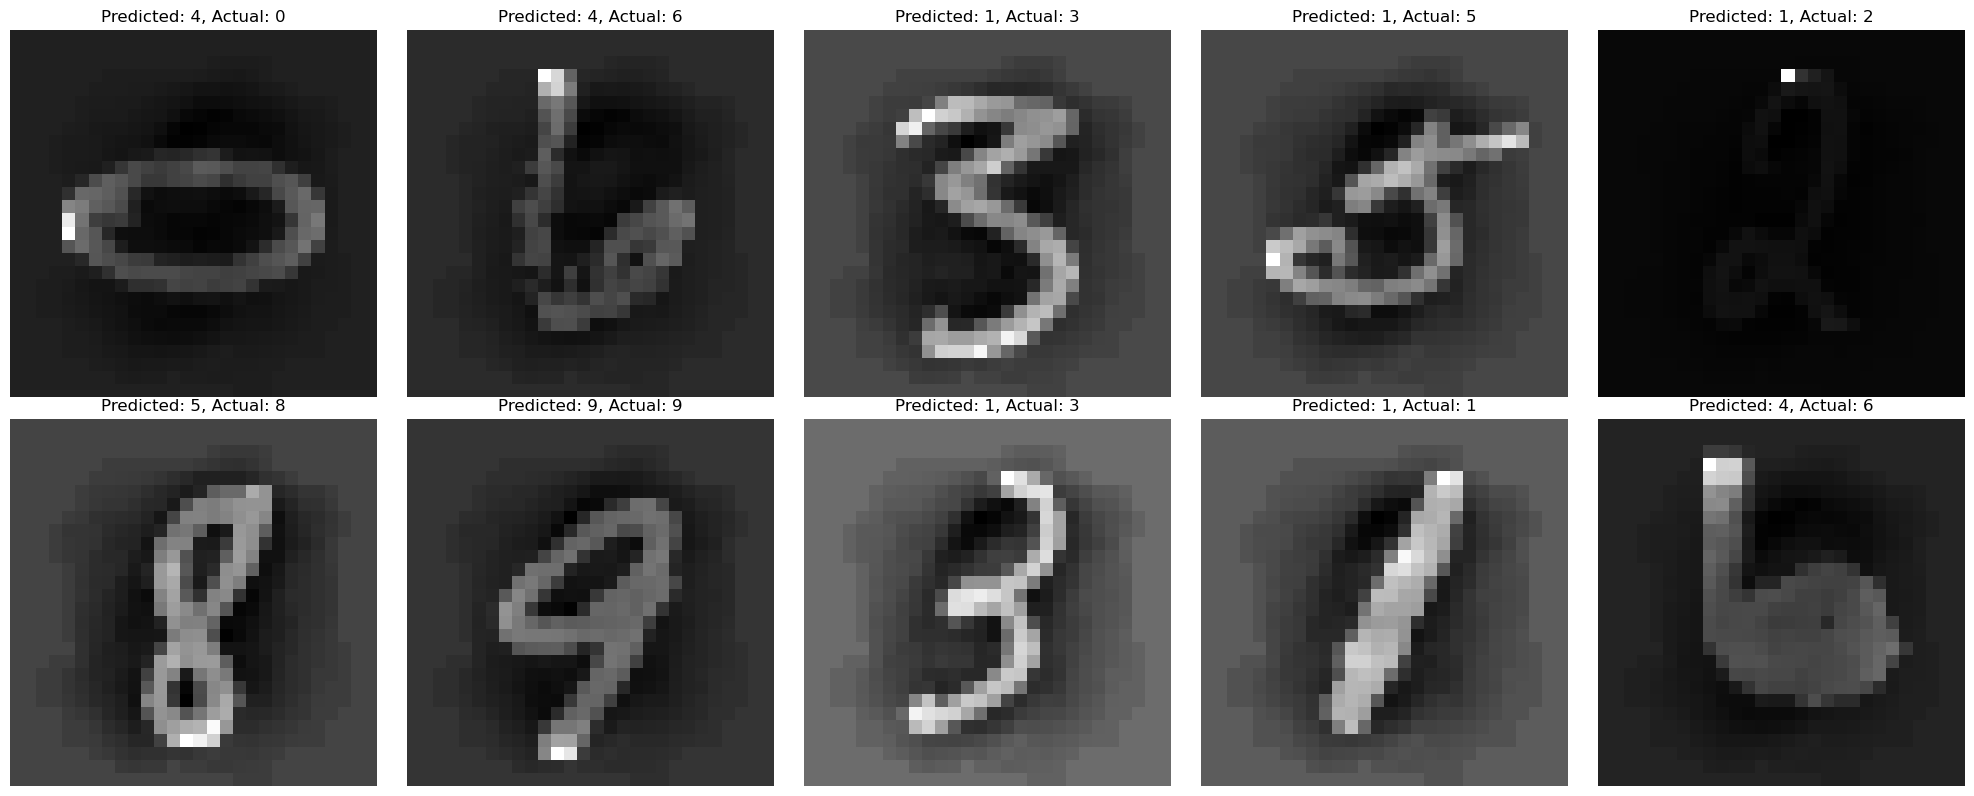

In [24]:
# Choose random indices to visualize
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Predict labels for the chosen test samples
predicted_labels = knn.predict(X_test[random_indices])

# Visualize the test images along with their predicted labels
plt.figure(figsize=(20, 8))
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}, Actual: {y_test[index]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

The accuracy of the only KNN on dataset MNIST is already good enough. 
Therefore,I try on antoher dataset:CIFAR-10,to see the difference.

<font face = "Times New Roman">

# Adaboost with KNN On CIFAR-10 Dataset

## 1.Load the CIFAR-10 dataset

</font>

The utility function `eecs598.data.cifar10()` returns the entire CIFAR-10 dataset as a set of four **Torch tensors**:

- `x_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [1]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [5]:
x_train, y_train, x_test, y_test = eecs598.data.cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([50000, 3, 32, 32])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 3, 32, 32])
  labels shape torch.Size([10000])


#### Visualization

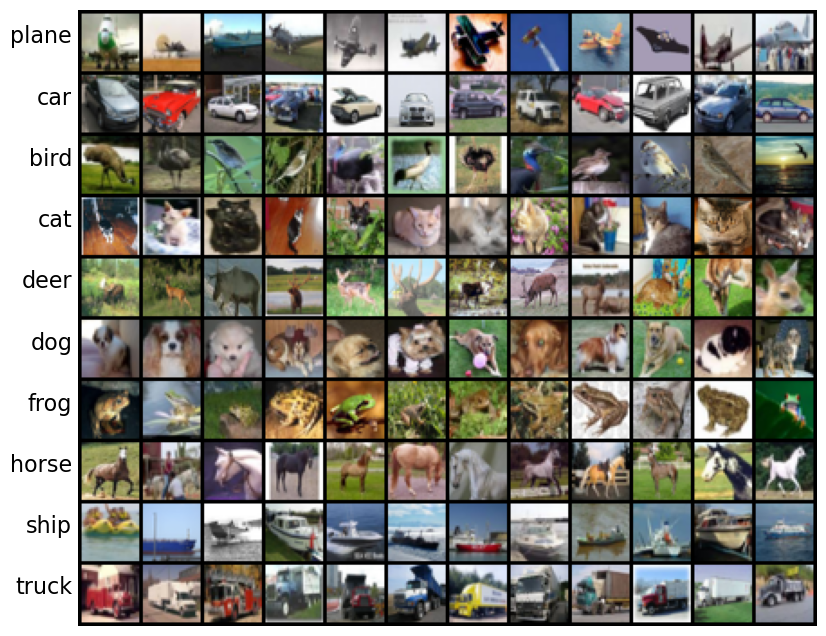

In [3]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(eecs598.tensor_to_image(img))
plt.axis('off')
plt.show()

<font face = "Times New Roman">

#### Preprocessing the data

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
X_train = x_train
X_test = x_test
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


<font face = "Times New Roman">

## 2.Implementing the KNN algorithm

Note : Detailed implementation of KNN can be seen in `knn.py` ,which is part of the homework of the course `EECS 598 - Deep Learning for Computer Vision` at the University of Michigan.

Earlier, I have implemented the KNN algorithm. Now, I will use the KNN algorithm as a weak learner in the Adaboost algorithm.

* Randomly select a `k` value for KNN, say k = 5 in this case.

* The accuracy of the KNN model is calculated.

In [111]:
from knn import KnnClassifier
torch.manual_seed(0)
x_train_all, y_train_all, x_test_all, y_test_all = eecs598.data.cifar10()

x_train = x_train_all[:500]
y_train = y_train_all[:500]
x_test = x_test_all[:500]
y_test = y_test_all[:500]

In [112]:
classifier = KnnClassifier(x_train, y_train)
for k in [1, 3, 5, 8, 10, 12, 20, 50]:
    print(f"K = {k}", end=' ')
    classifier.check_accuracy(x_test, y_test,k=k)

K = 1 Got 111 / 500 correct; accuracy is 22.20%
K = 3 Got 107 / 500 correct; accuracy is 21.40%
K = 5 Got 96 / 500 correct; accuracy is 19.20%
K = 8 Got 93 / 500 correct; accuracy is 18.60%
K = 10 Got 99 / 500 correct; accuracy is 19.80%
K = 12 Got 96 / 500 correct; accuracy is 19.20%
K = 20 Got 97 / 500 correct; accuracy is 19.40%
K = 50 Got 107 / 500 correct; accuracy is 21.40%


<font face = "Times New Roman">

## 3.Adaboost with KNN

### Basic Idea

Step 1: Initialize the weights of the training samples. Initially, all the weights are equal.

Step 2: For each weak learner, do the following:

    a. Train the weak learner on the training data with the weights.
    
    b. Calculate the error of the weak learner.
    
    c. Update the weights of the training samples.

Step 3: Combine the weak learners to form a strong learner.



In [106]:
import numpy as np
from knn import KnnClassifier
from sklearn.metrics import accuracy_score

##########################################################################
#                      Adaboost with KNN weak learners                   #  
#  Parameters:                                                           #
#  x_train: np.array, shape (n_samples, n_features)                      #
#  y_train: np.array, shape (n_samples,)                                 #
#  x_test: np.array, shape (n_samples, n_features)                       #
#  y_test: np.array, shape (n_samples,)                                  #
#  n_estimators: int                                                     #
##########################################################################                     

class Adaboost:    
    def __init__(self, x_train, y_train, x_test, y_test, n_estimators=10):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.n_estimators = n_estimators
        self.estimator_weights = []
        self.estimator_k_values = []
        self.best_estimators = []
    ###################################################
    #      Fit the model with training data           #
    ###################################################
    def fit(self):
        n_samples = self.x_test.shape[0]
        sample_weights = torch.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            # Train a weak learner with dynamically selected K value
            k_values = [1,2, 3, 5,7, 8, 12]  # Example K values to choose from
            min_error = np.inf
            best_k = 1
            best_y_pred = None
            best_estimator = None
            #########################################
            #  Iterate through the weak learners    #
            #  Find the best K value                #
            #########################################
            #print(sample_weights)
            for k in k_values:
                #print(sample_weights)
                # Train KNN classifier with current K value
                # Make predictions on training set
                print(f"K: {k}", end=' ')
                classifier = KnnClassifier(x_train_all, y_train_all)
                y_pred = classifier.predict(self.x_test,k=k)
                incorrect = (y_pred != y_test).int()
                #print(incorrect.shape)
                #print(sample_weights.shape)
                
                error = torch.sum(sample_weights * incorrect) / torch.sum(sample_weights)

                print(f"K: {k}, Error: {error:.8f}")
                # Update best K value
                if error < min_error:
                    min_error = error
                    best_k = k
                    best_estimator = classifier
                    best_y_pred = y_pred
                    

            print(f"Iteration {_ + 1} Best K: {best_k}, Best Error: {min_error:.8f}")
            #print(y_pred)
            #print(best_y_pred)
            error = min_error
            # Calculate estimator weight
            estimator_weight = 0.5 * np.log((1 - 0.5*error) / (0.5*error + 1e-20))
            # Save the estimator and its weight
            self.estimator_k_values.append(best_k)
            self.best_estimators.append(best_estimator)
            self.estimator_weights.append(estimator_weight)
            
            #print(f"y_pred: {best_y_pred}")
            #print(f"y_test: {self.y_test}")

            # Update sample weights
            sample_weights *= torch.exp(-estimator_weight *((y_pred == y_test).int()* 2 - 1))
            sample_weights /= torch.sum(sample_weights)
            

    ###################################################
    #     Predict the class labels for test data      #
    ###################################################
    def predict(self, x,y):
        n_samples = x.shape[0]
        Y_pred = torch.zeros(n_samples, 10)
        for estimator_weight,k,estimator in zip(self.estimator_weights,self.estimator_k_values,self.best_estimators):
            y_pred = estimator.predict(x,k=k)
            for i in range(n_samples):
                Y_pred[i,y_pred[i]] += estimator_weight
        y_pred = torch.argmax(Y_pred,dim=1)
        #print(y_pred)
        return y_pred


<font face = "Times New Roman">

#### Training the Adaboost model

In [107]:
adaboost = Adaboost(x_train, y_train, x_test, y_test, n_estimators=10)
adaboost.fit()

K: 1 K: 1, Error: 0.67199999
K: 2 K: 2, Error: 0.71000010
K: 3 K: 3, Error: 0.68400007
K: 5 K: 5, Error: 0.67199999
K: 7 K: 7, Error: 0.68800002
K: 8 K: 8, Error: 0.66600001
K: 12 K: 12, Error: 0.67400002
Iteration 1 Best K: 8, Best Error: 0.66600001
K: 1 K: 1, Error: 0.73847008
K: 2 K: 2, Error: 0.78148985
K: 3 K: 3, Error: 0.76238626
K: 5 K: 5, Error: 0.76001412
K: 7 K: 7, Error: 0.78990752
K: 8 K: 8, Error: 0.77917498
K: 12 K: 12, Error: 0.80549204
Iteration 2 Best K: 1, Best Error: 0.73847008
K: 1 K: 1, Error: 0.77418894
K: 2 K: 2, Error: 0.81990612
K: 3 K: 3, Error: 0.80450851
K: 5 K: 5, Error: 0.80730987
K: 7 K: 7, Error: 0.84466910
K: 8 K: 8, Error: 0.83999139
K: 12 K: 12, Error: 0.87615150
Iteration 3 Best K: 1, Best Error: 0.77418894
K: 1 K: 1, Error: 0.79536444
K: 2 K: 2, Error: 0.84268069
K: 3 K: 3, Error: 0.82948011
K: 5 K: 5, Error: 0.83534855
K: 7 K: 7, Error: 0.87713385
K: 8 K: 8, Error: 0.87604564
K: 12 K: 12, Error: 0.91804099
Iteration 4 Best K: 1, Best Error: 0.79536

<font face = "Times New Roman">

#### Testing the Adaboost model

In [108]:
y_pred = adaboost.predict(x_test,y_test)
print("#"*50)
#print("y_pred:{}\n".format(y_pred))
#print("y_test:{}\n".format(y_test_all))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

##################################################
Accuracy: 0.328
